## The Apprentice UK Outcomes

In [70]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re 
from transformers import pipeline
import matplotlib.pyplot as plt

The data we want to see is in the "Performance Chart" section and the "Episodes" summaries. These are tables are offset indexed 1 and 2 respectively.

I'm going to extract the data I need iteratively and load to a db - this is in part cause I started this project on the long train home, relying on a meagre pay-as-you-go limit, and in part as I don't any database management today and want to get some practice in!

### Episode Summaries data

Staring with the Episodes table, there are 2 row classes that we care about: `expand-child` and `vevent module-episode-list-row`. These contain an episode summary and episode key data respectively, which we will need to join together.

In [2]:
# For dropping table
with sqlite3.connect("database.db") as conn:
    conn.execute("DROP TABLE IF EXISTS episode_summaries")
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    print("Tables:", tables)

Tables: []


In [3]:
## Run the first time
with sqlite3.connect("database.db") as conn:
    conn.execute("CREATE TABLE episode_summaries (episode_id INTEGER, episode_num INTEGER, task_title TEXT, task_description TEXT, series_number INTEGER)")
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    print("Tables:", tables)

Tables: [('episode_summaries',)]


In [4]:
def get_and_store_page_content(series_num: int, SNMAX=20):
    """
    Fetches the content of a Wikipedia page for a given series number and stores it locally.
    SNMAX (int, optional): The maximum series number, currently 19 (20 ongoing at time of writing).
    """
    assert series_num > 0 and series_num <= SNMAX and isinstance(series_num, int), "series_num must be a positive integer below 20"
    url = f"https://en.m.wikipedia.org/wiki/The_Apprentice_(British_TV_series)_series_{series_num}"
    page = requests.get(url)
    page_content = page.content
    with open(f"pages/series_{series_num}.html", "wb") as f:
        f.write(page_content)
    return page_content

def get_html_tables(series_num: int, bypass_page_check=False):
    assert series_num > 0 and isinstance(series_num, int), "series_num must be a positive integer"
    try:
        with open(f"pages/series_{series_num}.html", "r") as f:
            page_content = f.read()
    except FileNotFoundError:
        if bypass_page_check or input("Page not found. Download page? (y/n)").lower() == "y":
            page_content = get_and_store_page_content(series_num)
        else:
            return None
    soup = BeautifulSoup(page_content, 'html.parser')
    return soup.find_all('table', class_='wikitable')

def add_episode_summaries_row(series_num: int, bypass_page_check=False, db_path="database.db"):
    """
    Fetches and parses the episode summaries for a given series number, and stores them in the database.
    Table index 2 is the episode summaries table.
    """
    html_table = get_html_tables(series_num, bypass_page_check=bypass_page_check)[2]
    parsed_rows = parse_html_table(html_table)
    if parsed_rows is None:
        return None
    
    ## Add the series number to the parsed rows
    parsed_rows = [(row[0], row[1], row[2], row[3], series_num) for row in parsed_rows]

    ## We need to use a SQL parameter method to insert data with odd characters like '
    sql_template = "INSERT INTO episode_summaries(episode_id, episode_num, task_title, task_description, series_number) VALUES(?, ?, ?, ?, ?)"
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.executemany(sql_template, parsed_rows)
    conn.commit()
    conn.close()
    
    return parsed_rows

def parse_episode_header(html_row):
    """
    Parses the header row of an episode table.
    """
    header = html_row.find_all('th')
    assert len(header) == 1, "Header row must have exactly header one cell"
    episode_id = header[0].text
    cells = html_row.find_all('td')
    episode_num = cells[0].text
    task = cells[1].text
    return episode_id, episode_num, task

def parse_episode_summary(html_row):
    return html_row.text.replace("\n", "")

def parse_html_table(html_table):
    """
    Parses an HTML table of episode summaries into a list of episodal rows represented by tuples.
    Each row is a header html_row followed by a summary html_row, which need to be collected into one
    tuple.
    """
    html_rows = html_table.find_all('tr')
    end_rows = []
    current_row = [0,0,0,0]
    for html_row in html_rows:
        if html_row.get('class') == ['vevent', 'module-episode-list-row']:
            parsed_table_row = parse_episode_header(html_row)

            ## We ignore the special (retrospective) episodes, as they give us
            ## no new information about the competition, and their formats are
            ## different. Special episode numbers aren't entirely numeric
            if not parsed_table_row[1].isnumeric():
                continue
            current_row[0], current_row[1], current_row[2] = parsed_table_row

            # The episode title format needs to be parsed
            current_row[2] = re.search(r"\"(.+)\"", current_row[2]).group(1)
        elif html_row.get('class') == ['expand-child']:
            if current_row[0] == 0:
                continue
            current_row[3] = parse_episode_summary(html_row)
            end_rows.append(current_row)
            current_row = [0,0,0,0]
    return end_rows

In [5]:
## Run the first time
for i in range(1, 20):
    add_episode_summaries_row(i, bypass_page_check=True);
    

In [6]:
df_es = pd.read_sql("SELECT * FROM episode_summaries", sqlite3.connect("database.db"), index_col="episode_id")
df_es

,episode_num,task_title,task_description,series_number
episode_id,,,,
1,1,Wilting Blooms,Sir Alan Sugar begins a search for an apprenti...,1
2,2,Child's Play,Teams put their creative skills to the test wh...,1
3,3,Shop Till You Drop,"On their next task, Sir Alan assigns both team...",1
4,4,The Harrods Sales,Given a concession stand to run within Harrods...,1
5,5,Art with a Capital F,Both teams find themselves each representing a...,1
...,...,...,...,...
256,8,Hot Sauce,Lord Sugar challenges the teams to develop the...,19
257,9,TV Selling,The teams are given the instructions for this ...,19
258,10,Fashion,The teams are sent to London College of Fashio...,19


In [7]:
# df_es.to_csv("episode_summaries.csv")

### Performance Chart data

In [7]:
with sqlite3.connect("database.db") as conn:
    conn.execute("DROP TABLE IF EXISTS performance_chart")
    conn.execute("DROP TABLE IF EXISTS candidates")
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    print("Tables:", tables)

Tables: [('episode_summaries',)]


The chart schema is as follows:
- `Candidate` - the name of the candidate (Primary Key) TEXT
- `results` - the performance of the candidate in week n (where n is the week number) TEXT. This will be one of
    - `PM` - Project Manager and fired
    - `FIRED` - Fired but not PM
    - `BR` - Brought back to the boardroom but not fired
    - `LOSE` - Lost task as PM but not fired
    - `LOSS` - Lost task but not fired or brought back
    - `IN` - In the winning team
    - `WIN` - Won task as PM
    - `RUNNER UP` - Runner up in the final
    - `WINNER` - Winner of the series




In [8]:
result_decoder = {"a": "PM", "b": "FIRED", "c": "BR", "d": "LOSE", "e": "LOSS", "f": "IN", "g": "WIN", "h": "RUNNER-UP", "i": "HIRED", "j": "LEFT"}
result_encoder = {v: k for k, v in result_decoder.items()}
result_encoder["WINNER"] = "i"
result_encoder["QUIT"] = "j"

In [9]:
SCHEMA = [f'week_{n}_result TEXT' for n in range(1, 12)]

with sqlite3.connect("database.db") as conn:
    conn.execute(f"CREATE TABLE performance_chart (candidate TEXT, results_encoded TEXT)")
    conn.execute("CREATE TABLE candidates (candidate TEXT, background TEXT, age INTEGER)")
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    print("Tables:", tables)

Tables: [('episode_summaries',), ('performance_chart',), ('candidates',)]


Full candidate names are in the 0 index table. There is one excess candidate, series 5's Adam Freeman, who quit before the start of the process.

In [10]:
# Row 0 is header, others are candidates

def add_candidate_rows(series_num: int, bypass_page_check=False, db_path="database.db"):
    table = get_html_tables(series_num, bypass_page_check=bypass_page_check)[0]
    candidate_rows = table.find_all('tr')[1:]
    #drop the reason for firing column
    candidate_rows = [tuple(row.get_text("--", strip=True).split("--")[:3]) for row in candidate_rows]
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.executemany("INSERT INTO candidates(candidate, background, age) VALUES(?, ?, ?)", candidate_rows)
    conn.commit()
    conn.close()
    return candidate_rows

def add_performance_rows(series_num: int, bypass_page_check=False, db_path="database.db"):
    # TODO Add thing to parse performance table for ongoing series
    tables = get_html_tables(series_num, bypass_page_check=bypass_page_check)[1]
    candidate_records = tables.find_all('tr')[2:]
    candidate_records = [candidate_record.get_text("--", strip=True).split("--") for candidate_record in candidate_records]
    encoded_records = [(r[0], "".join([result_encoder[result] for result in r[1:]])) for r in candidate_records]
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.executemany("INSERT INTO performance_chart(candidate, results_encoded) VALUES(?, ?)", encoded_records)
    conn.commit()
    conn.close()
    return encoded_records

def get_week_n_result(results_string: str, n: int):
    if len(results_string) < n:
        return None
    return result_decoder[results_string[n-1]]

def make_week_n_result_column(df, n):
    df[f'week_{n}'] = df['results_encoded'].apply(lambda x: get_week_n_result(x, n))
    return df
    

In [11]:
for i in range(1, 19):
    try:
        add_candidate_rows(i, bypass_page_check=True);
        add_performance_rows(i, bypass_page_check=True);
    except Exception as e:
        print(i)
        print(e)


In [12]:
df_p = pd.read_sql("SELECT * FROM performance_chart", sqlite3.connect("database.db"))

In [13]:
df_p = pd.read_sql("SELECT * FROM performance_chart", sqlite3.connect("database.db"))

for i in range(1, 13):
    df_p = make_week_n_result_column(df_p, i)
df_names = pd.read_sql("SELECT candidate FROM candidates WHERE candidate<>\"Adam Freeman\"", sqlite3.connect("database.db"))
df_p["candidate_id"] = df_names
df_p.drop("results_encoded", axis=1, inplace=True)

# Check that the candidate ids within each series match up with the given candidate names

#Typically the first names should match
#Some candidates are known by a nickname, which is given in quotes in the candidate id (from candidates)
df_p["candidate_id_matched"] = (
    df_p['candidate_id'].str.split(" ", expand=True)[0] == df_p['candidate'].str.split(" ", expand=True)[0]
    ) | (
        df_p['candidate_id'].str.extract(r'\"([^\"]*)"').fillna('')[0] == df_p['candidate'].str.split(" ", expand=True)[0]
    )

assert df_p["candidate_id_matched"].all(), "Some candidate names do not match the full name"
assert df_p["candidate_id"].unique().shape[0] == df_p.shape[0], "Some candidate names are not unique"

df_p.drop("candidate_id_matched", axis=1, inplace=True)

df_p.to_csv("performance_chart.csv")
df_p.to_sql("performance_chart_processed", sqlite3.connect("database.db"), if_exists="replace", index=False)

297

In [14]:
df_p = pd.read_sql("SELECT * FROM performance_chart_processed", sqlite3.connect("database.db"), index_col="candidate_id")
df_p

,candidate,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12
candidate_id,,,,,,,,,,,,,
Tim Campbell,Tim,WIN,IN,LOSS,LOSE,IN,IN,IN,LOSS,IN,BR,IN,HIRED
Saira Khan,Saira,LOSE,LOSS,IN,IN,LOSS,BR,LOSS,IN,LOSE,IN,IN,RUNNER-UP
Paul Torrisi,Paul,IN,IN,IN,IN,BR,LOSE,IN,BR,WIN,BR,FIRED,None
James Max,James,IN,IN,IN,WIN,IN,IN,LOSE,IN,BR,WIN,FIRED,None
Miriam Staley,Miriam,LOSS,BR,LOSS,LOSS,IN,WIN,IN,BR,IN,PM,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jack Davies,Jack,LOSS,LOSS,LOSS,PM,None,None,None,None,None,None,None,None
Amina Khan,Amina,IN,IN,BR,FIRED,None,None,None,None,None,None,None,None
Asif Munaf,Asif,LOSS,BR,PM,None,None,None,None,None,None,None,None,None


### Summarising episodal descriptions

##### Description Classifier

In [55]:
from transformers import DistilBertTokenizerFast
from sklearn.preprocessing import LabelEncoder
import torch

In [56]:
episode_labels = pd.read_csv("episode_task_category_labels.csv")
classes = list(episode_labels.Category.unique())

# Load the data
episode_summaries = pd.read_csv("episode_summaries.csv")

# Merge the datasets on Episode Num and Series Num
data = episode_summaries.merge(
    episode_labels,
    left_on=["episode_num", "series_number"],
    right_on=["Episode Num", "Series Num"]
)

data

,episode_id,episode_num,task_title,task_description,series_number,Episode Num,Series Num,Category
0,1,1,Wilting Blooms,Sir Alan Sugar begins a search for an apprenti...,1,1,1,Sales
1,2,2,Child's Play,Teams put their creative skills to the test wh...,1,2,1,Product Development
2,3,3,Shop Till You Drop,"On their next task, Sir Alan assigns both team...",1,3,1,Procurement / Scavenger Hunt
3,4,4,The Harrods Sales,Given a concession stand to run within Harrods...,1,4,1,Store/Production-line
4,5,5,Art with a Capital F,Both teams find themselves each representing a...,1,5,1,High-end Sales
...,...,...,...,...,...,...,...,...
79,92,8,Paris,Each team splits in half on a marketing task –...,7,8,7,Event / Trade Sales
80,93,9,Biscuit,Each team must manufacture a brand new type of...,7,9,7,General Business
81,94,10,Flip It,Both teams are each given a £250 pallet of who...,7,10,7,Sales
82,96,11,Fast Food Chain,"In their penultimate task, each team must inve...",7,11,7,General Business


In [57]:
# Prepare the input text and labels
data["text"] = "Title: " + data["task_title"] + ".\nDescription: " + data["task_description"]
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["Category"])



tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [58]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: DistilBertTokenizerFast):
        self.encodings = tokenizer(data['text'].to_list(), truncation=True, padding=True)
        self.labels = data["label"].to_list()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}


In [49]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(label_encoder.classes_)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="no",
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=TextDataset(data, tokenizer)
)
trainer.train()

c:\Users\Jacob\miniconda3\envs\tauk\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
10,2.699100
20,2.563700
30,2.475600
40,2.251500
50,2.246900


TrainOutput(global_step=55, training_loss=2.420262822237882, metrics={'train_runtime': 14.1469, 'train_samples_per_second': 29.688, 'train_steps_per_second': 3.888, 'total_flos': 28150672548600.0, 'train_loss': 2.420262822237882, 'epoch': 5.0})

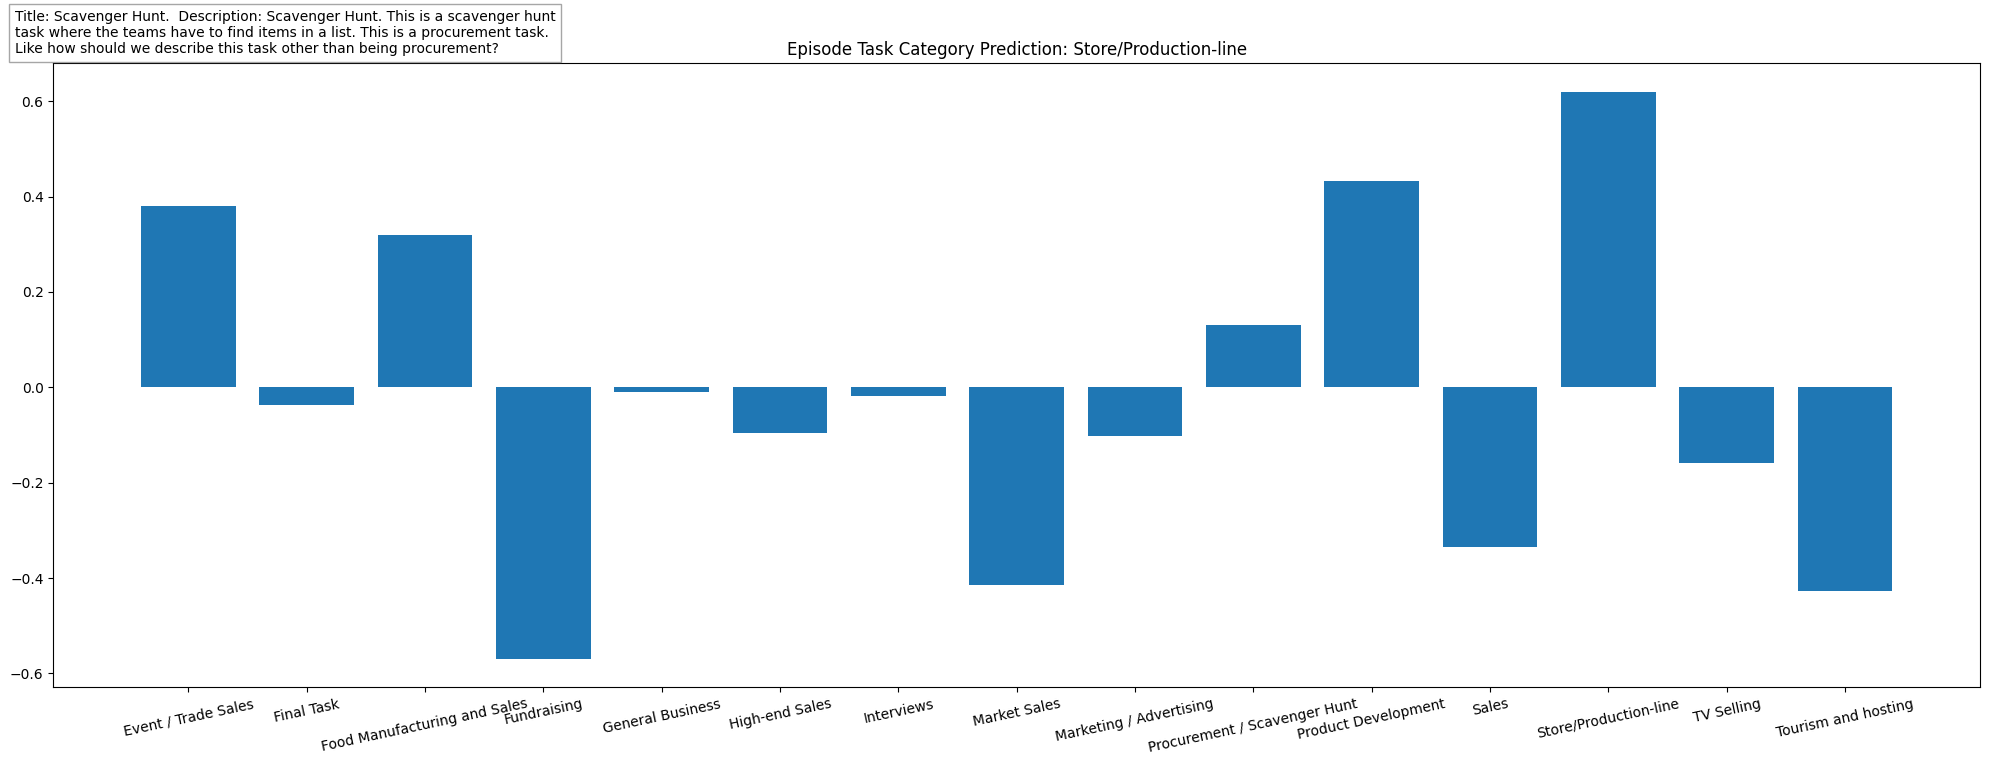

In [105]:
import textwrap

test_text = "Title: Scavenger Hunt. \nDescription: Scavenger Hunt. This is a scavenger hunt task where the teams have to find items in a list. This is a procurement task. Like how should we describe this task other than being procurement?"
inputs = tokenizer(test_text, return_tensors="pt", truncation=True, padding=True)
model.to("cpu")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits, dim=1)
pred_label = label_encoder.inverse_transform(pred.numpy())

fig = plt.figure(figsize=(20, 8))
plt.title("Episode Task Category Prediction: " + str(pred_label[0]))
plt.bar(label_encoder.classes_, outputs.logits.detach().numpy().flatten())
plt.xticks(rotation=12);

wrapped_text = "\n".join(textwrap.wrap(test_text, width=80))
plt.gcf().text(0.01, 0.95, wrapped_text, fontsize=10, va='top', ha='left', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.tight_layout(rect=[0, 0, 1, 0.93])
